In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 1.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


#### Load necessary packages

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as st
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_validate,GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,StandardScaler,LabelBinarizer,OneHotEncoder,Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from numpy import isnan
from sklearn.impute import SimpleImputer


### Load train and test dataset

In [138]:
train=pd.read_csv("/content/gdrive/MyDrive/cipla-data-scientist-hiring-challenge/train.csv")
test=pd.read_csv("/content/gdrive/MyDrive/cipla-data-scientist-hiring-challenge/test.csv")

### One category column level is missing in test dataset. So combine the train and test and again split the data

In [139]:
full_data=pd.concat([train,test],axis=0)

In [140]:
train=full_data[full_data['Loan Sanction Amount (USD)'].notnull()]
test=full_data[full_data['Loan Sanction Amount (USD)'].isnull()]

### Let's see missing value counts in each column

In [9]:
train.isnull().sum()

Customer ID                       0
Name                              0
Gender                           52
Age                               0
Income (USD)                   4493
Income Stability               1658
Profession                        0
Type of Employment             7188
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     167
Expense Type 1                    0
Expense Type 2                    0
Dependents                     2446
Credit Score                   1670
No. of Defaults                   0
Has Active Credit Card         1546
Property ID                       0
Property Age                   4760
Property Type                     0
Property Location               347
Co-Applicant                      0
Property Price                    0
Loan Sanction Amount (USD)        0
dtype: int64

#### The above information explain that the target column(Loan Sanction Amount (USD)) also has missing value.

#### Let's remove the target column missing rows

In [141]:
new_train=train[train['Loan Sanction Amount (USD)'].notnull()]

#### Now again check the missing values

In [ ]:
new_train.isnull().sum()

Customer ID                       0
Name                              0
Gender                           52
Age                               0
Income (USD)                   4493
Income Stability               1658
Profession                        0
Type of Employment             7188
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     167
Expense Type 1                    0
Expense Type 2                    0
Dependents                     2446
Credit Score                   1670
No. of Defaults                   0
Has Active Credit Card         1546
Property ID                       0
Property Age                   4760
Property Type                     0
Property Location               347
Co-Applicant                      0
Property Price                    0
Loan Sanction Amount (USD)        0
dtype: int64

### Create list of column name that has missing values.

In [142]:
missing_val_cols=list(new_train.columns[new_train.isnull().any()])

### Let's create a missing value indicator column that is if column has missing value return 1 otherwise 0.

In [143]:
indicator_col=new_train[missing_val_cols].isnull().astype(int).add_suffix('_indicator')

### Concatenate new_train and indicator_col

In [144]:
new_train=pd.concat([new_train,indicator_col],axis=1)

In [145]:
new_train.head(3)

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),Gender_indicator,Income (USD)_indicator,Income Stability_indicator,Type of Employment_indicator,Current Loan Expenses (USD)_indicator,Dependents_indicator,Credit Score_indicator,Has Active Credit Card_indicator,Property Age_indicator,Property Location_indicator
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933,54607.18,0,0,0,0,0,0,0,1,0,0
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791,37469.98,0,0,0,1,0,0,0,0,0,0
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.6,36474.43,0,0,0,1,0,0,0,0,0,0


### Let's re-arrange the indicator column 

In [146]:
new_train=new_train.iloc[:,np.r_[0:3,24,3,4,25,5,26,6,7,27,8,9,10,28,11:14,29,14,30,15,16,31,17,18,32,19,20,33,21:24]]

In [147]:
new_train.head(3)

,Customer ID,Name,Gender,Gender_indicator,Age,Income (USD),Income (USD)_indicator,Income Stability,Income Stability_indicator,Profession,Type of Employment,Type of Employment_indicator,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Current Loan Expenses (USD)_indicator,Expense Type 1,Expense Type 2,Dependents,Dependents_indicator,Credit Score,Credit Score_indicator,No. of Defaults,Has Active Credit Card,Has Active Credit Card_indicator,Property ID,Property Age,Property Age_indicator,Property Type,Property Location,Property Location_indicator,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,0,56,1933.05,0,Low,0,Working,Sales staff,0,Semi-Urban,72809.58,241.08,0,N,N,3.0,0,809.44,0,0,NaN,1,746,1933.05,0,4,Rural,0,1,119933,54607.18
1,C-33999,America Calderone,M,0,32,4952.91,0,Low,0,Working,NaN,1,Semi-Urban,46837.47,495.81,0,N,Y,1.0,0,780.40,0,0,Unpossessed,0,608,4952.91,0,2,Rural,0,1,54791,37469.98
2,C-3770,Rosetta Verne,F,0,65,988.19,0,High,0,Pensioner,NaN,1,Semi-Urban,45593.04,171.95,0,N,Y,1.0,0,833.15,0,0,Unpossessed,0,546,988.19,0,2,Urban,0,0,72440.6,36474.43


### Let's check how many levels under each categorical column

In [17]:
for i in new_train.iloc[:,np.r_[2,5,7,9,10,12,16,17,18,22,23,28,29,31]].columns:
  print(new_train[i].value_counts())


M    14890
F    14718
Name: Gender, dtype: int64
1608.43    4
2415.70    4
1617.97    3
1868.78    3
1992.30    3
          ..
1545.90    1
1440.24    1
2131.37    1
1409.10    1
1216.00    1
Name: Income (USD), Length: 24187, dtype: int64
Low     25458
High     2544
Name: Income Stability, dtype: int64
Working                 16739
Commercial associate     7863
Pensioner                2718
State servant            2334
Businessman                 2
Unemployed                  2
Maternity leave             1
Student                     1
Name: Profession, dtype: int64
Laborers                 5516
Sales staff              3698
Core staff               3189
Managers                 2464
Drivers                  1588
Accountants              1363
High skill tech staff    1297
Medicine staff            854
Security staff            574
Cooking staff             561
Cleaning staff            338
Private service staff     337
Secretaries               158
Low-skill Laborers        154
Wait

#### The above summary shows that property location column has unknown negative value. So change the negative value to null

In [148]:
new_train['Co-Applicant'].replace({-999:np.nan},inplace=True)

#### Now co_applicant column has some missinng values.Let's create a missing value indicator column for co-applicant

In [149]:
new_train['Co-Applicant_Indicator']=new_train['Co-Applicant'].isnull().astype('int')

In [92]:
new_train['Co-Applicant_Indicator'].value_counts()

0    29495
1      165
Name: Co-Applicant_Indicator, dtype: int64

### Let's see numerical column number summary

In [21]:
for i in new_train.iloc[:,np.r_[4,5,13,14,18,20,26,31,32]].columns:
  print(new_train[i].describe())

count    29660.000000
mean        40.099225
std         16.050024
min         18.000000
25%         25.000000
50%         40.000000
75%         55.000000
max         65.000000
Name: Age, dtype: float64
count    2.516700e+04
mean     2.630991e+03
std      1.131902e+04
min      3.777000e+02
25%      1.650250e+03
50%      2.223300e+03
75%      3.090330e+03
max      1.777460e+06
Name: Income (USD), dtype: float64
count     29660.000000
mean      88792.057274
std       59480.995253
min        6048.240000
25%       41200.112500
50%       75114.085000
75%      119890.857500
max      621497.820000
Name: Loan Amount Request (USD), dtype: float64
count    29493.000000
mean       400.893752
std        242.265401
min       -999.000000
25%        247.780000
50%        375.090000
75%        521.050000
max       3840.880000
Name: Current Loan Expenses (USD), dtype: float64
count    27214.000000
mean         2.253399
std          0.951987
min          1.000000
25%          2.000000
50%          2.0000

#### The above column-wise numerical summary shows that there is the same type of negative value are in some rows. SO let's change this as a null value.

In [150]:
new_train['Current Loan Expenses (USD)'].replace({-999:np.nan},inplace=True)

#### Now current loan expenses column has some missing values so let's create a missing value indicator for the loan expenses column

In [151]:
new_train['Current Loan Expenses (USD)_indicator']=new_train['Current Loan Expenses (USD)'].isnull().astype('int')

#### Property price column has the same type of negative value are in some rows. SO let's change this as a null value.

In [152]:
new_train['Property Price'].replace({-999:np.nan},inplace=True)

#### Now property price column has some missing values so let's create a missing value indicator for the property price

In [153]:
new_train['Property Price_indicator']=new_train['Property Price'].isnull().astype('int')

#### Re-arrange the newly created columns

In [154]:
new_train=new_train.iloc[:,np.r_[0:32,34,32,35,33]]

In [ ]:
new_train.head(2)

,Customer ID,Name,Gender,Gender_indicator,Age,Income (USD),Income (USD)_indicator,Income Stability,Income Stability_indicator,Profession,Type of Employment,Type of Employment_indicator,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Current Loan Expenses (USD)_indicator,Expense Type 1,Expense Type 2,Dependents,Dependents_indicator,Credit Score,Credit Score_indicator,No. of Defaults,Has Active Credit Card,Has Active Credit Card_indicator,Property ID,Property Age,Property Age_indicator,Property Type,Property Location,Property Location_indicator,Co-Applicant,Co-Applicant_Indicator,Property Price,Property Price_indicator,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,0,56,1933.05,0,Low,0,Working,Sales staff,0,Semi-Urban,72809.58,241.08,0,N,N,3.0,0,809.44,0,0,NaN,1,746,1933.05,0,4,Rural,0,1.0,0,119933.46,0,54607.18
1,C-33999,America Calderone,M,0,32,4952.91,0,Low,0,Working,NaN,1,Semi-Urban,46837.47,495.81,0,N,Y,1.0,0,780.40,0,0,Unpossessed,0,608,4952.91,0,2,Rural,0,1.0,0,54791.00,0,37469.98


### Let's impute the missing values by using the sklearn's simpleimputer function.

### Numerical missing values are replaced by the mean
### Categorical missing values are replaced by mode

In [155]:
imputer = SimpleImputer(strategy='most_frequent')
imputer2 = SimpleImputer(strategy='mean')

### Select the categorical column

In [156]:
cat_col_imp=['Gender','Income Stability','Type of Employment','Dependents','Has Active Credit Card','Property Location','Co-Applicant']

### Impute the missing categorical values.

In [157]:
for i in cat_col_imp:
  new_train[i]=imputer.fit_transform(new_train[[i]])

### Select the numerical column

In [158]:
num_col_imp=['Income (USD)','Current Loan Expenses (USD)','Credit Score','Property Age','Property Price']

### Impute the missing numerical values.

In [159]:
for i in num_col_imp:
  new_train[i]=imputer2.fit_transform(new_train[[i]])

### Create a new column total applicants by adding co-applicant column values with 1.

In [160]:
new_train['total_applicant']=new_train['Co-Applicant']+1

### Let's encode the two level categorical columns by using label encoder.

In [161]:
lbl_encode=LabelBinarizer()

In [162]:
lbl_enc_col=['Gender','Income Stability','Expense Type 1','Expense Type 2']
for i in lbl_enc_col:
  new_train[i]=lbl_encode.fit_transform(new_train[i])

### Let's encode the remaining category columns by using ordinal encoder.

In [163]:
ord_encode=OrdinalEncoder()

In [164]:
ord_enc_col=['Location','Profession','Type of Employment','Dependents','Has Active Credit Card','Property Location']
for i in ord_enc_col:
  new_train[i]=ord_encode.fit_transform(new_train[[i]])

In [165]:
final_train=new_train[new_train['Loan Sanction Amount (USD)']>0]

### Apply the missing value imputation and feature engineering steps to test dataset.

In [182]:
#missing value columns
missing_val_cols1=list(test.columns[test.isnull().any()])

#missing value indicator column
indicator_col1=test[missing_val_cols1].isnull().astype(int).add_suffix('_indicator')

#concatenate indicator column to test dataset
new_test=pd.concat([test,indicator_col1],axis=1)

#re-arrange column
new_test=new_test.iloc[:,np.r_[0:3,24,3,4,25,5,26,6,7,27,8,9,10,28,11,12,13,29,14,30,15,16,31,17,18,32,19,20,33,21,22]]

#replace "?" as null value
new_test['Co-Applicant'].replace({'?':np.nan},inplace=True)

#create missing value indicator column for co-applicant column
new_test['Co-Applicant_Indicator']=new_test['Co-Applicant'].isnull().astype('int')

#convert co-applicant column data type to int
new_test['Co-Applicant']=new_test['Co-Applicant'].astype('float',errors='ignore')

#replace "?" as null value
new_test['Property Price'].replace({'?':np.nan},inplace=True)

#create missing value indicator column for property price column
new_test['Property Price_indicator']=new_test['Property Price'].isnull().astype('int')

#re-arrange column
new_test=new_test.iloc[:,np.r_[0:32,33,32,34]]


In [184]:
#category column missing values imputation
for i in cat_col_imp:
  new_test[i]=imputer.fit_transform(new_test[[i]])

#numerical column missing values imputation
for i in num_col_imp:
  new_test[i]=imputer2.fit_transform(new_test[[i]])

In [185]:
#create total applicant column
new_test['total_applicant']=new_test['Co-Applicant']+1


#encode two-level category columns
for i in lbl_enc_col:
  new_test[i]=lbl_encode.fit_transform(new_test[i])

#encode remaining category column
for i in ord_enc_col:
  new_test[i]=ord_encode.fit_transform(new_test[[i]])


### Create Independent Features and target feature

In [186]:
X=final_train.drop(columns=['Loan Sanction Amount (USD)','Customer ID','Name','Property ID'])
y=final_train['Loan Sanction Amount (USD)']

### Create a XGBRegressor Model

In [52]:
xgreg=xgb.XGBRegressor(random_state=5)

### Set values for hyperparameters 

In [53]:
params={'xgreg__learning_rate':np.linspace(0.001,1.0,num=5,dtype='float'),
        'xgreg__max_depth':np.linspace(2,12,num=7,dtype='int')}

### Split the train data into 12 parts by using shufflesplit

In [55]:
cv_split=ShuffleSplit(n_splits=12,test_size=0.2,random_state=5)

### Create a Gridsearchcv

In [111]:
grid=GridSearchCV(xgreg,param_grid=params,scoring='r2',cv=cv_split,verbose=100,return_train_score=True)

### Fit the model

In [112]:
grid.fit(X,y)

Fitting 12 folds for each of 35 candidates, totalling 420 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] xgreg__learning_rate=0.001, xgreg__max_depth=2 ..................
[06:58:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  xgreg__learning_rate=0.001, xgreg__max_depth=2, score=(train=0.991, test=0.990), total=   2.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[CV] xgreg__learning_rate=0.001, xgreg__max_depth=2 ..................
[06:58:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  xgreg__learning_rate=0.001, xgreg__max_depth=2, score=(train=0.991, test=0.990), total=   2.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[CV] xgreg__learning_rate=0.001, xgreg__max_depth=2 ..................
[06:58:54] WARNING: /worksp

GridSearchCV(cv=ShuffleSplit(n_splits=12, random_state=5, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=...
                                    objective='reg:linear', random_state=5,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'xgreg__learning_rate': array([0.00

In [122]:
print(f"The Best GridSearchCV Score:{grid.best_score_}\n",
       "_"*100,
      f"\n\nThe Best Parameters are:{grid.best_params_}")

The Best GridSearchCV Score:0.9891575722986358
 ____________________________________________________________________________________________________ 

The Best Parameters are:{'xgreg__learning_rate': 0.001, 'xgreg__max_depth': 2}


In [125]:
res_feat=pd.Series(xgreg.feature_importances_,index=X.columns)

### Feature Importance plot

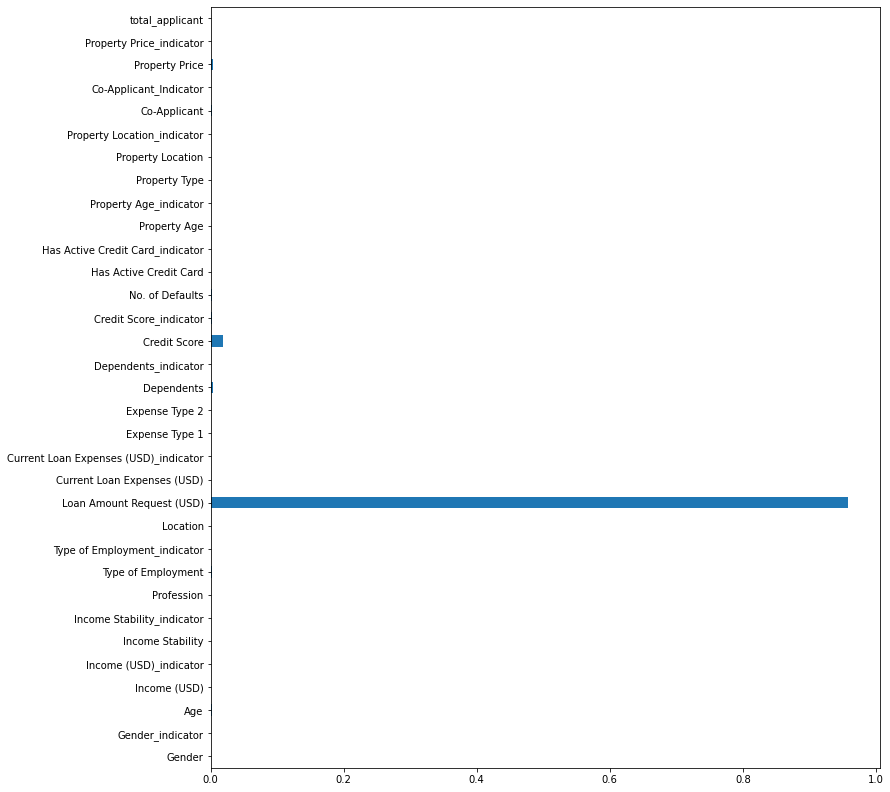

In [127]:
plt.figure(figsize=(12,14))
res_feat.plot(kind='barh')

In [197]:
cv_results=pd.DataFrame(grid.cv_results_)

### Cross-validation train and test error

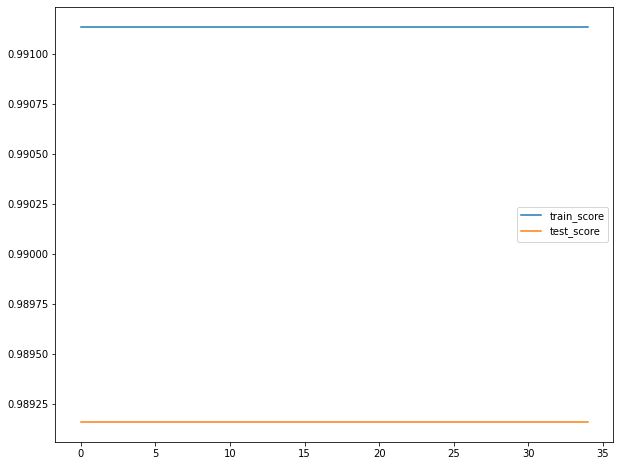

In [210]:
plt.figure(figsize=(10,8))
plt.plot(cv_results['mean_train_score'],label='train_score')
plt.plot(cv_results['mean_test_score'],label='test_score')
plt.legend()

In [211]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgreg__learning_rate,param_xgreg__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,1.984409,0.016636,0.015689,0.000527,0.001,2,"{'xgreg__learning_rate': 0.001, 'xgreg__max_de...",0.989515,0.989647,0.98949,0.987221,0.990238,0.987498,0.989941,0.989634,0.987569,0.989831,0.988994,0.990313,0.989158,0.001054,1,0.991216,0.991122,0.991191,0.991189,0.990965,0.991121,0.991106,0.99114,0.99113,0.991204,0.991283,0.990966,0.991136,0.00009
1,1.988330,0.024717,0.015705,0.000320,0.001,3,"{'xgreg__learning_rate': 0.001, 'xgreg__max_de...",0.989515,0.989647,0.98949,0.987221,0.990238,0.987498,0.989941,0.989634,0.987569,0.989831,0.988994,0.990313,0.989158,0.001054,1,0.991216,0.991122,0.991191,0.991189,0.990965,0.991121,0.991106,0.99114,0.99113,0.991204,0.991283,0.990966,0.991136,0.00009
2,1.983449,0.015391,0.015603,0.000165,0.001,5,"{'xgreg__learning_rate': 0.001, 'xgreg__max_de...",0.989515,0.989647,0.98949,0.987221,0.990238,0.987498,0.989941,0.989634,0.987569,0.989831,0.988994,0.990313,0.989158,0.001054,1,0.991216,0.991122,0.991191,0.991189,0.990965,0.991121,0.991106,0.99114,0.99113,0.991204,0.991283,0.990966,0.991136,0.00009
3,1.991942,0.014639,0.015883,0.000500,0.001,7,"{'xgreg__learning_rate': 0.001, 'xgreg__max_de...",0.989515,0.989647,0.98949,0.987221,0.990238,0.987498,0.989941,0.989634,0.987569,0.989831,0.988994,0.990313,0.989158,0.001054,1,0.991216,0.991122,0.991191,0.991189,0.990965,0.991121,0.991106,0.99114,0.99113,0.991204,0.991283,0.990966,0.991136,0.00009
4,1.992256,0.008288,0.016016,0.001211,0.001,8,"{'xgreg__learning_rate': 0.001, 'xgreg__max_de...",0.989515,0.989647,0.98949,0.987221,0.990238,0.987498,0.989941,0.989634,0.987569,0.989831,0.988994,0.990313,0.989158,0.001054,1,0.991216,0.991122,0.991191,0.991189,0.990965,0.991121,0.991106,0.99114,0.99113,0.991204,0.991283,0.990966,0.991136,0.00009


### Hyperparameter's Score

<Figure size 1080x576 with 0 Axes>

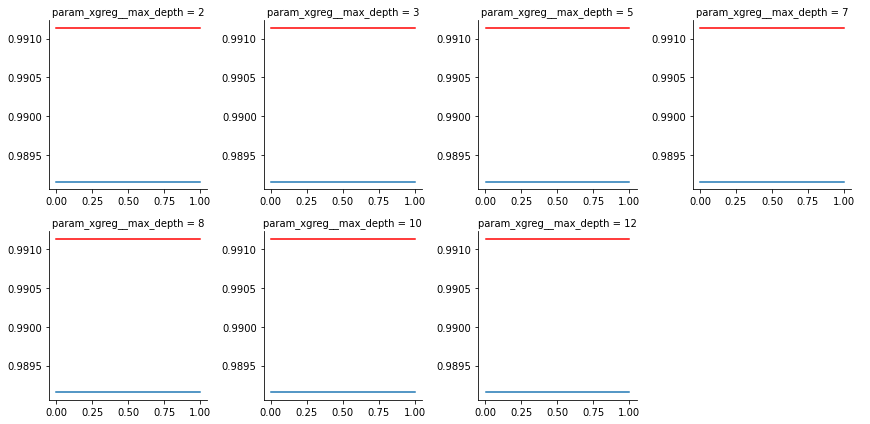

In [229]:
_=plt.figure(figsize=(15,8))
g = sns.FacetGrid(cv_results, col="param_xgreg__max_depth",col_wrap=4,sharex=False, 
                  sharey=False)
g.map_dataframe(sns.lineplot, x="param_xgreg__learning_rate",
                y='mean_train_score',color='red')
g.map_dataframe(sns.lineplot, x="param_xgreg__learning_rate",
                y='mean_test_score')

### Test data predict

In [187]:
test_predict=grid.predict(new_test.drop(columns=['Customer ID','Name','Property ID']))

In [193]:
result_sub=pd.DataFrame({'Customer ID':new_test['Customer ID'],'Loan Sanction Amount(USD)':test_predict})

In [194]:
result_sub

,Customer ID,Loan Sanction Amount(USD)
108,C-14817,39087.039062
114,C-24508,92113.156250
290,C-18811,53837.875000
322,C-15078,53065.660156
421,C-17364,105754.531250
...,...,...
19995,C-9076,105572.265625
19996,C-17587,32843.867188
19997,C-46479,14338.073242
19998,C-3099,73575.828125
